In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pipedream_solver.hydraulics import SuperLink

%matplotlib inline

# Specify model parameters

In [2]:
superjunctions_string = '''
name	id	z_inv	h_0	bc	storage	a	b	c	max_depth	map_x	map_y
11	0	216.408	0	FALSE	functional	0	0	1e-3	inf	30	70
12	1	213.36	0	FALSE	functional	0	0	1e-3	inf	50	70
13	2	211.836	0	FALSE	functional	0	0	1e-3	inf	70	70
21	3	213.36	0	FALSE	functional	0	0	1e-3	inf	30	40
22	4	211.836	0	FALSE	functional	0	0	1e-3	inf	50	40
23	5	210.312	0	FALSE	functional	0	0	1e-3	inf	70	40
31	6	213.36	0	FALSE	functional	0	0	1e-3	inf	30	10
32	7	216.408	0	FALSE	functional	0	0	1e-3	inf	50	10
r9	8	243.5352	0.3048	TRUE	functional	0	0	1	inf	10	70
t2	9	259.08	36.576	FALSE	functional	0	0	186.0757398	inf	50	90
i1	10	213.36	0	FALSE	functional	0	0	1e0	inf	50	70
'''

superlinks_string = '''
name	id	sj_0	sj_1	in_offset	out_offset	dx	n	shape	g1	g2	g3	g4	Q_0	h_0	ctrl	A_s	A_c	C
11	0	0	1	0	0	1609.344	0.013	force_main	0.3556	0.00001	0	0	0	0.3556	FALSE	1.00E-04	0	0
12	1	1	2	0	0	1609.344	0.013	force_main	0.254	0.00001	0	0	0	0.254	FALSE	1.00E-04	0	0
21	2	3	4	0	0	1609.344	0.013	force_main	0.254	0.00001	0	0	0	0.254	FALSE	1.00E-04	0	0
22	3	4	5	0	0	1609.344	0.013	force_main	0.3048	0.00001	0	0	0	0.3048	FALSE	1.00E-04	0	0
31	4	6	7	0	0	1609.344	0.013	force_main	0.1524	0.00001	0	0	0	0.1524	FALSE	1.00E-04	0	0
110	5	10	1	0	0	60.96	0.013	force_main	0.4572	0.00001	0	0	0	0.4572	FALSE	1.00E-04	0	0
111	6	0	3	0	0	1609.344	0.013	force_main	0.254	0.00001	0	0	0	0.254	FALSE	1.00E-04	0	0
112	7	1	4	0	0	1609.344	0.013	force_main	0.3048	0.00001	0	0	0	0.3048	FALSE	1.00E-04	0	0
113	8	2	5	0	0	1609.344	0.013	force_main	0.2032	0.00001	0	0	0	0.2032	FALSE	1.00E-04	0	0
121	9	3	6	0	0	1609.344	0.013	force_main	0.2032	0.00001	0	0	0	0.2032	FALSE	1.00E-04	0	0
122	10	4	7	0	0	1609.344	0.013	force_main	0.1524	0.00001	0	0	0	0.1524	FALSE	1.00E-04	0	0
1	11	8	0	0	0	304.8	0.013	force_main	0.3048	0.00001	0	0	0	0.3048	FALSE	1.00E-04	0	0
'''

orifices_string = '''
name	id	sj_0	sj_1	A	orientation	z_o	y_max	C
0	0	9	10	0.164	side	0	0.4572	0.67
'''

Notes:

- Superjunction nodal areas set to 1e-3 $m^2$---can be made smaller.
- Preissman slot width set to 0.00001 (0.001%) of pipe diameter---can be made smaller.
- Internal junction nodal areas set to 1e-4 $m^2$ each---can be made smaller.

In [3]:
superjunctions = pd.read_csv(io.StringIO(superjunctions_string), sep='\t')
superlinks = pd.read_csv(io.StringIO(superlinks_string), sep='\t')
orifices = pd.read_csv(io.StringIO(orifices_string), sep='\t')

# View model parameter tables

In [4]:
superjunctions

,name,id,z_inv,h_0,bc,storage,a,b,c,max_depth,map_x,map_y
0,11,0,216.4080,0.0000,False,functional,0,0,0.00100,inf,30,70
1,12,1,213.3600,0.0000,False,functional,0,0,0.00100,inf,50,70
2,13,2,211.8360,0.0000,False,functional,0,0,0.00100,inf,70,70
3,21,3,213.3600,0.0000,False,functional,0,0,0.00100,inf,30,40
4,22,4,211.8360,0.0000,False,functional,0,0,0.00100,inf,50,40
5,23,5,210.3120,0.0000,False,functional,0,0,0.00100,inf,70,40
6,31,6,213.3600,0.0000,False,functional,0,0,0.00100,inf,30,10
7,32,7,216.4080,0.0000,False,functional,0,0,0.00100,inf,50,10
8,r9,8,243.5352,0.3048,True,functional,0,0,1.00000,inf,10,70
9,t2,9,259.0800,36.5760,False,functional,0,0,186.07574,inf,50,90


In [5]:
superlinks

,name,id,sj_0,sj_1,in_offset,out_offset,dx,n,shape,g1,g2,g3,g4,Q_0,h_0,ctrl,A_s,A_c,C
0,11,0,0,1,0,0,1609.344,0.013,force_main,0.3556,0.00001,0,0,0,0.3556,False,0.0001,0,0
1,12,1,1,2,0,0,1609.344,0.013,force_main,0.2540,0.00001,0,0,0,0.2540,False,0.0001,0,0
2,21,2,3,4,0,0,1609.344,0.013,force_main,0.2540,0.00001,0,0,0,0.2540,False,0.0001,0,0
3,22,3,4,5,0,0,1609.344,0.013,force_main,0.3048,0.00001,0,0,0,0.3048,False,0.0001,0,0
4,31,4,6,7,0,0,1609.344,0.013,force_main,0.1524,0.00001,0,0,0,0.1524,False,0.0001,0,0
5,110,5,10,1,0,0,60.960,0.013,force_main,0.4572,0.00001,0,0,0,0.4572,False,0.0001,0,0
6,111,6,0,3,0,0,1609.344,0.013,force_main,0.2540,0.00001,0,0,0,0.2540,False,0.0001,0,0
7,112,7,1,4,0,0,1609.344,0.013,force_main,0.3048,0.00001,0,0,0,0.3048,False,0.0001,0,0
8,113,8,2,5,0,0,1609.344,0.013,force_main,0.2032,0.00001,0,0,0,0.2032,False,0.0001,0,0
9,121,9,3,6,0,0,1609.344,0.013,force_main,0.2032,0.00001,0,0,0,0.2032,False,0.0001,0,0


In [6]:
orifices

,name,id,sj_0,sj_1,A,orientation,z_o,y_max,C
0,0,0,9,10,0.164,side,0,0.4572,0.67


# Specify model inputs

In [7]:
# Reservoir boundary head (m)
H_bc = np.array([0, 0, 0, 0, 0, 0, 0, 0, 243.84, 0, 0])
# Constant demand input (cms)
Q_in = -6.309e-5 * np.array([150, 150, 100, 150, 200, 150, 100, 100, 0, 0, 0])

# Instantiate model

In [8]:
# Specify number of internal links in each superlink and timestep size in seconds
internal_links = 12
dt = 30
u_o = np.zeros(1)

# Instantiate the model (note that this takes a while the first time because numba has to compile the code)
model = SuperLink(superlinks, superjunctions, orifices=orifices, 
                  internal_links=internal_links)
# Spin up model at small timestep to 'settle' initial states
model.spinup(n_steps=500, dt=0.1, H_bc=H_bc, u_o=u_o)

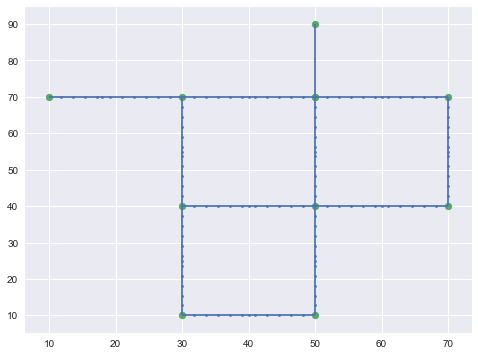

In [9]:
# Plot pipe network
fig, ax = plt.subplots(figsize=(8,6))
_ = model.plot_network_2d(ax=ax, junction_kwargs={'s' : 6})

# Run model with sinusoidal demand

In [10]:
H = []
Q = []

# While time is less than 24 hours
while model.t < (24 * 3600):
    # If tank level is above minimum, keep tank open...
    if model.H_j[9] > (0.3048 * 950):
        u_o = np.ones(1)
    # Else, close the tank
    else:
        u_o = np.zeros(1)
    # Let demand input be sinusoidal
    Q_in_t = (1 + 0.6*np.sin(model.t / 4 / 3600)) * Q_in
    model.step(dt=dt, H_bc=H_bc, Q_in=Q_in_t, u_o=u_o)
    H.append(model.H_j.copy())
    Q.append(model.Q_ik.copy())
    
H = np.vstack(H)
Q = np.vstack(Q)

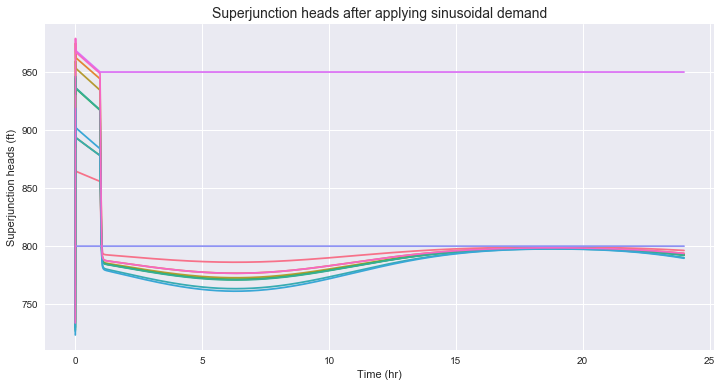

In [11]:
# Plot results
sns.set_palette('husl', model.M)
fig, ax = plt.subplots(figsize=(12, 6))
_ = plt.plot((dt * np.arange(len(H)) / 3600), H / 0.3048)
plt.xlabel('Time (hr)')
plt.ylabel('Superjunction heads (ft)')
_ = plt.title('Superjunction heads after applying sinusoidal demand', size=14)